# **Detection of Female and Male eyes using Convolutional Neural Networks**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eyes-rtte/maleeyes/3863.jpg
/kaggle/input/eyes-rtte/maleeyes/623.jpg
/kaggle/input/eyes-rtte/maleeyes/2193.jpg
/kaggle/input/eyes-rtte/maleeyes/3750.jpg
/kaggle/input/eyes-rtte/maleeyes/2008.jpg
/kaggle/input/eyes-rtte/maleeyes/5982.jpg
/kaggle/input/eyes-rtte/maleeyes/2081.jpg
/kaggle/input/eyes-rtte/maleeyes/6588.jpg
/kaggle/input/eyes-rtte/maleeyes/3919.jpg
/kaggle/input/eyes-rtte/maleeyes/6197.jpg
/kaggle/input/eyes-rtte/maleeyes/6399.jpg
/kaggle/input/eyes-rtte/maleeyes/3757.jpg
/kaggle/input/eyes-rtte/maleeyes/4489.jpg
/kaggle/input/eyes-rtte/maleeyes/3417.jpg
/kaggle/input/eyes-rtte/maleeyes/5705.jpg
/kaggle/input/eyes-rtte/maleeyes/764.jpg
/kaggle/input/eyes-rtte/maleeyes/5307.jpg
/kaggle/input/eyes-rtte/maleeyes/5039.jpg
/kaggle/input/eyes-rtte/maleeyes/1700.jpg
/kaggle/input/eyes-rtte/maleeyes/6324.jpg
/kaggle/input/eyes-rtte/maleeyes/1075.jpg
/kaggle/input/eyes-rtte/maleeyes/4969.jpg
/kaggle/input/eyes-rtte/maleeyes/5584.jpg
/kaggle/input/eyes-rtte/maleeyes/350

# **Imports from libraries**

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image

# **Organizing Training and Testing Dataframes**

In [3]:
# Selecting Dataset Folder Paths
f_dir_ = Path('../input/eyes-rtte/femaleeyes')
m_dir_ = Path('../input/eyes-rtte/maleeyes')
femaleeyes_filepaths = list(f_dir_.glob(r'**/*.jpg'))
maleeyes_filepaths = list(m_dir_.glob(r'**/*.jpg'))

# Mapping the labels
fm_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], femaleeyes_filepaths))
ml_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], maleeyes_filepaths))

# Paths & labels femalee eyes
fm_filepaths = pd.Series(femaleeyes_filepaths, name = 'File').astype(str)
fm_labels = pd.Series(fm_labels, name='Label')

# Paths & labels malee eyes
ml_filepaths = pd.Series(maleeyes_filepaths, name = 'File').astype(str)
ml_labels = pd.Series(ml_labels, name='Label')

# Concatenating...
femaleeyes_df = pd.concat([fm_filepaths, fm_labels], axis=1)
maleeyes_df = pd.concat([ml_filepaths, ml_labels], axis=1)

df = pd.concat([femaleeyes_df, maleeyes_df])

df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)

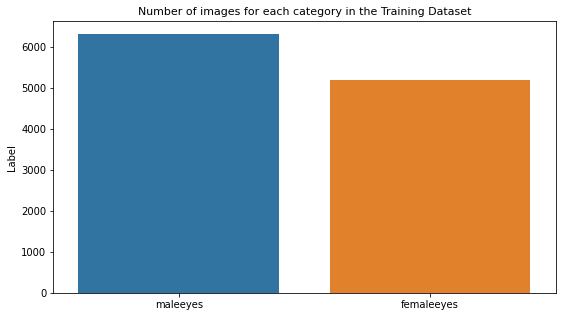

In [5]:
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

# **Observing the images**

In [7]:
plt.style.use("dark_background")

Text(0.5, 1.0, 'maleeyes')

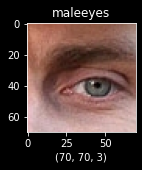

In [8]:
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["File"][34])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][34])

Text(0.5, 1.0, 'femaleeyes')

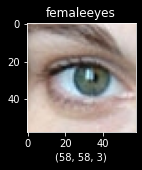

In [9]:
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["File"][11])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][11])

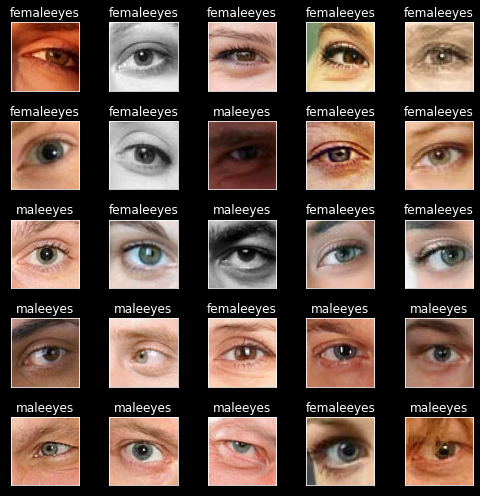

In [10]:
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

# **Dividing into training and testing sets**

In [11]:
trainset_df, testset_df = train_test_split(df, train_size = 0.75, random_state = 4)

display(trainset_df.head())

testset_df.head()

,File,Label
5614,../input/eyes-rtte/maleeyes/7262.jpg,maleeyes
862,../input/eyes-rtte/femaleeyes/3775.jpg,femaleeyes
9030,../input/eyes-rtte/femaleeyes/128.jpg,femaleeyes
7482,../input/eyes-rtte/maleeyes/889.jpg,maleeyes
5000,../input/eyes-rtte/maleeyes/3309.jpg,maleeyes


,File,Label
3814,../input/eyes-rtte/femaleeyes/6254.jpg,femaleeyes
5238,../input/eyes-rtte/femaleeyes/5784.jpg,femaleeyes
2768,../input/eyes-rtte/femaleeyes/6847.jpg,femaleeyes
2398,../input/eyes-rtte/maleeyes/4254.jpg,maleeyes
9093,../input/eyes-rtte/maleeyes/306.jpg,maleeyes


In [12]:
# converting the Label to a numeric format for testing later...
LE = LabelEncoder()

y_test = LE.fit_transform(testset_df["Label"])

In [13]:
# Viewing data in training dataset
print('Training Dataset:')

print(f'Number of images: {trainset_df.shape[0]}')

print(f'Number of images with malee eyes: {trainset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {trainset_df["Label"].value_counts()[1]}\n')

# Viewing data in test dataset
print('Test Dataset:')

print(f'Number of images: {testset_df.shape[0]}')

print(f'Number of images with malee eyes: {testset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {testset_df["Label"].value_counts()[1]}\n')

Training Dataset:
Number of images: 8643
Number of images with malee eyes: 4729
Number of images with femalee eyes: 3914

Test Dataset:
Number of images: 2882
Number of images with malee eyes: 1594
Number of images with femalee eyes: 1288



# **Generating batches of images**

**Parameters of ImageDataGenerator:**

rescale - Transform image size (normalization of data)
shear_range - Random geometric transformations
zoom_range - Images that will be zoomed
rotation_range - Degree of image rotation
width_shift_range - Image Width Change Range
height_shift_range - Image height change range
horizontal_flip - Rotate images horizontally
vertical_flip - Rotate images vertically
validation_split - Images that have been reserved for validation (0-1)

In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

# **Directory of training, validation and test images**

**Parameters of flow_from_directory:**

dataframe - Dataframe containing the images directory
x_col - Column name containing the images directory
y_col - Name of the column containing what we want to predict
target_size - size of the images (remembering that it must be the same size as the input layer)
color_mode - RGB color standard
class_mode - binary class mode (cat/dog)
batch_size - batch size (32)
shuffle - Shuffle the data
seed - optional random seed for the shuffle
subset - Subset of data being training and validation (only used if using validation_split in ImageDataGenerator)

In [15]:
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 32)

print('Data generators are ready!')

Preparing the training dataset ...
Found 7779 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 864 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 2882 validated image filenames belonging to 2 classes.
Data generators are ready!


In [16]:
print("Training: ")
print(training_set.class_indices)
print(training_set.image_shape)
print("---" * 8)
print("Validation: ")
print(validation_set.class_indices)
print(validation_set.image_shape)
print("---" * 8)
print("Test: ")
print(test_set.class_indices)
print(test_set.image_shape)

Training: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)
------------------------
Validation: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)
------------------------
Test: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)


**EarlyStopping parameters:**

monitor - Metrics that will be monitored
patience - Number of times without improvement in the model, after these times the training is stopped
restore_best_weights - Restores best weights if training is interrupted

In [31]:
# Callbacks
cb = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 15, restore_best_weights = True)]

# **Construction of the first model (ConvNet)**
**Model Sequential**

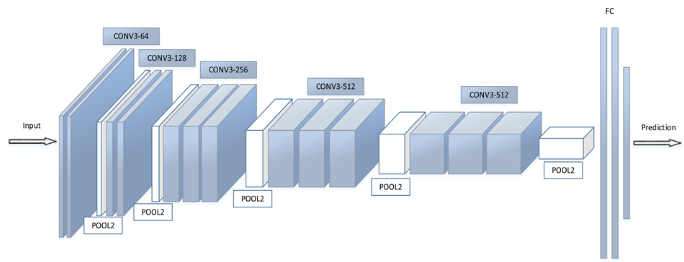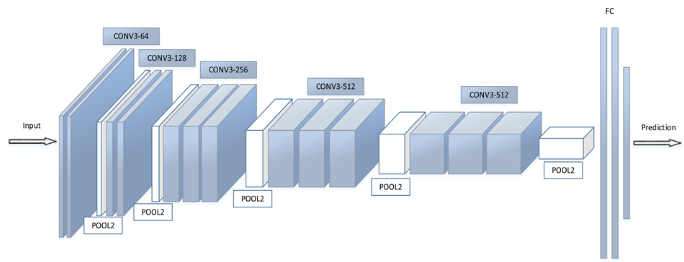

> ***Step 1 - Convolution***

Feature Detector and Feature Map

Number of filters (32)

Dimensions of the feature detector (3, 3)

Definition of height / width and RGB channels (128, 128, 3)

Activation function to remove negative values from the image - 'relu'

Processing acceleration - BatchNormalization

In [17]:
CNN = Sequential()

CNN.add(Conv2D(32, (3, 3), input_shape = (75, 75, 3), activation = 'relu'))
CNN.add(BatchNormalization())

2023-01-18 17:19:43.088037: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


> ***Step 2 - Max Pooling***

Reduced image size by focusing on the most important features

Matrix definition with a total of 4 pixels (2, 2)

In [18]:
CNN.add(MaxPooling2D(pool_size = (2, 2)))

> ***Step 3 - Hidden Layers***

In [19]:
CNN.add(Conv2D(32, (3, 3), activation = 'relu'))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

In [20]:
CNN.add(Conv2D(32, (3, 3), activation = 'relu'))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

> ***Step 4 - Flattening***

Transforming the matrix to a vector to enter the Artificial Neural Network layer

In [21]:
CNN.add(Flatten())

> ***Step 5 - Dense Neural Networks***

Parameters of the RNA:

Dense - All neurons connected

units - Number of neurons that are part of the hidden layer

activation - Activation function that will be inserted

Dropout - is used to decrease the chance of overfitting (20% of the input neurons are zeroed)

In [22]:
# Input layer
CNN.add(Dense(units = 128, activation = 'relu'))
CNN.add(Dropout(0.2))
# Output layer (binary classification)
CNN.add(Dense(units = 1, activation = 'sigmoid'))

print(CNN.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0

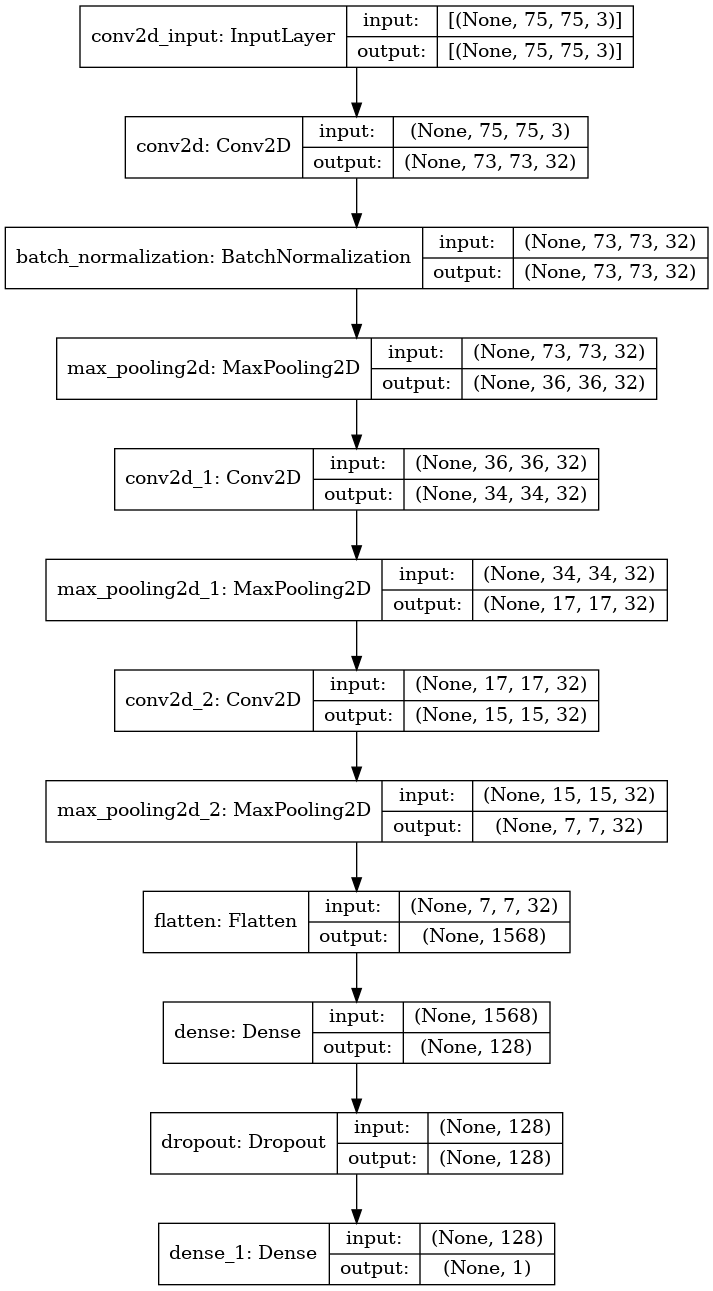

In [23]:
plot_model(CNN, to_file='CNN_model.png', show_layer_names = True , show_shapes = True)

> ***Step 6 - Model compilation and training***

**Compile parameters:**

optimizer - descent of the gradient and descent of the stochastic gradient

loss - Loss function (binary_crossentropy as there is only one exit)

metrics - Evaluation metrics (obs - more than one can be placed)

***Fit parameters:***

 train_data - training database
 
 epochs - number of seasons
 
 validation_data - test database
 
 callbacks - Using EarlyStopping
 
 validation_steps - number of images to validation

In [32]:
# Compile
CNN.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Start of counting time...
start = dt.datetime.now()

# Train
CNN_model = CNN.fit(training_set, epochs = 50, validation_data = validation_set, callbacks = cb)

# End of counting time...
end = dt.datetime.now()
time_CNN = end - start
print ('\nTraining and validation time is: ', time_CNN)

2023-01-18 17:25:26.781818: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
244/244 [==============================] - 61s 244ms/step - loss: 0.6340 - accuracy: 0.6498 - val_loss: 0.6347 - val_accuracy: 0.6748
Epoch 2/50
244/244 [==============================] - 40s 164ms/step - loss: 0.5239 - accuracy: 0.7405 - val_loss: 0.4927 - val_accuracy: 0.7731
Epoch 3/50
244/244 [==============================] - 40s 166ms/step - loss: 0.4698 - accuracy: 0.7744 - val_loss: 0.4383 - val_accuracy: 0.7975
Epoch 4/50
244/244 [==============================] - 39s 158ms/step - loss: 0.4284 - accuracy: 0.7980 - val_loss: 0.6143 - val_accuracy: 0.7025
Epoch 5/50
244/244 [==============================] - 41s 168ms/step - loss: 0.3881 - accuracy: 0.8258 - val_loss: 0.3970 - val_accuracy: 0.8264
Epoch 6/50
244/244 [==============================] - 38s 157ms/step - loss: 0.3652 - accuracy: 0.8421 - val_loss: 0.4968 - val_accuracy: 0.7951
Epoch 7/50
244/244 [==============================] - 41s 166ms/step - loss: 0.3673 - accuracy: 0.8410 - val_loss: 0.3574 - val_ac

> ***Step 7 - Model training history***

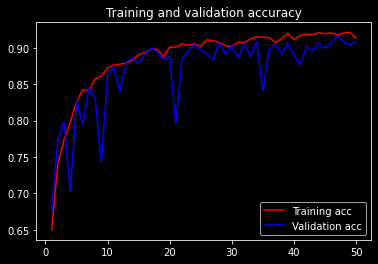

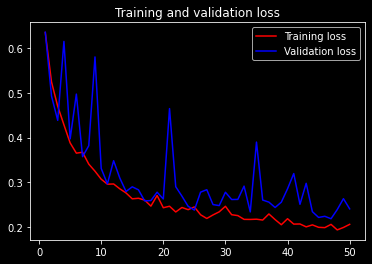

In [33]:
acc = CNN_model.history['accuracy']
val_acc = CNN_model.history['val_accuracy']
loss = CNN_model.history['loss']
val_loss = CNN_model.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

> ***Step 8 - Viewing results and generating forecasts***

In [34]:
score_CNN = CNN.evaluate(test_set)
print("Test Loss:", score_CNN[0])
print("Test Accuracy:", score_CNN[1])

91/91 [==============================] - 13s 139ms/step - loss: 0.1627 - accuracy: 0.9306
Test Loss: 0.16270503401756287
Test Accuracy: 0.9306037425994873


In [35]:
y_pred_CNN = CNN.predict(test_set)
y_pred_CNN = np.round(y_pred_CNN)

recall_CNN = recall_score(y_test, y_pred_CNN)
precision_CNN = precision_score(y_test, y_pred_CNN)
f1_CNN = f1_score(y_test, y_pred_CNN)
roc_CNN = roc_auc_score(y_test, y_pred_CNN)

In [36]:
print(classification_report(y_test, y_pred_CNN))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1288
           1       0.91      0.96      0.94      1594

    accuracy                           0.93      2882
   macro avg       0.93      0.93      0.93      2882
weighted avg       0.93      0.93      0.93      2882



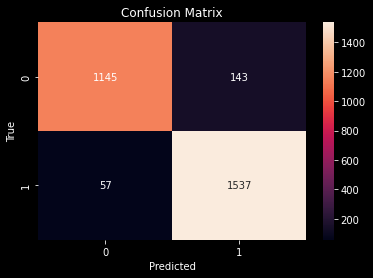

In [37]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_CNN),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [42]:
# Save the model
modelFileName = 'cats-dogs-classifier.h5'
CNN.save(modelFileName)
print('model saved as', modelFileName)

model saved as cats-dogs-classifier.h5


# **Construction of the second model (Inception)**

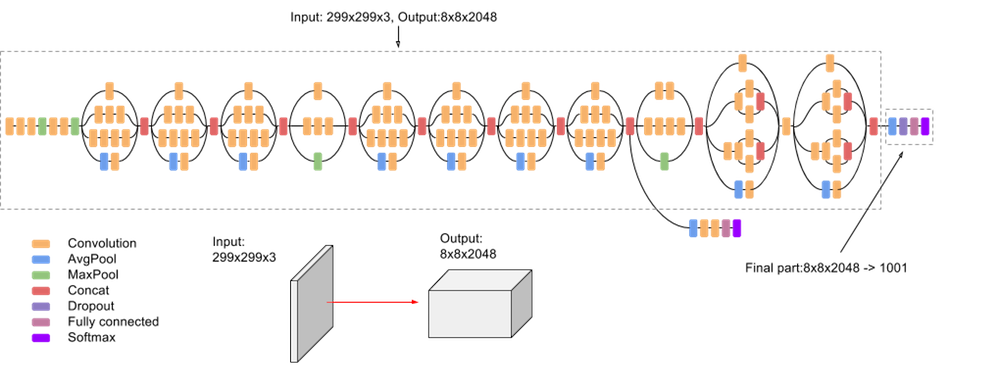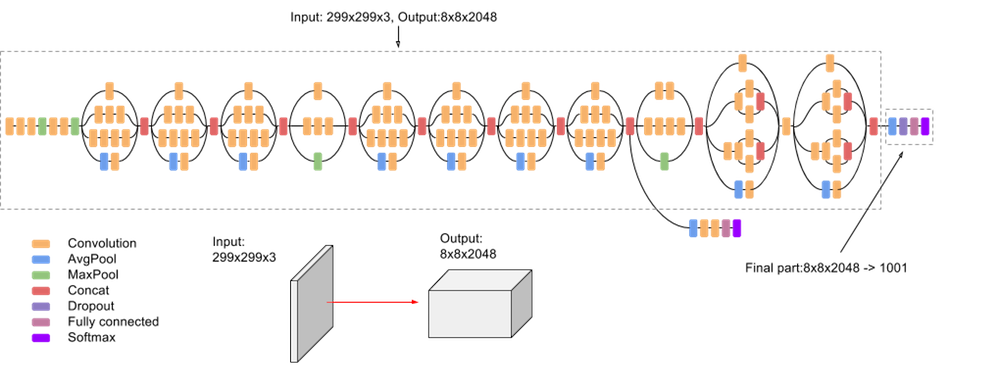

> ***Step 1 - Base model creation***

input_shape - Setting the height/width and RGB channels (128, 128, 3)

include_top - Fully connected layer will not be included on top

weights - Pre-training using None

In [61]:
CNN_base_inc = InceptionV3(input_shape = (75, 75, 3), include_top = False, weights = None)

In [62]:
for layer in CNN_base_inc.layers:
    layer.trainable = False

> ***Step 2 - Flattening***

Transforming the matrix to a vector to enter the Artificial Neural Network layer

In [63]:
x = layers.Flatten()(CNN_base_inc.output)

> ***Step 3 - Dense Neural Networks***

Dense - All connected neurons

units - Number of neurons that are part of the hidden layer

activation - Activation function that will be inserted

Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)

In [64]:
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(1, activation='sigmoid')(x)

CNN_inc = Model(CNN_base_inc.input, x)

> ***Step 4 - Model compilation and training***

**Compile parameters:**

optimizer - descent of the gradient and descent of the stochastic gradient

loss - Loss function (binary_crossentropy as there is only one exit)

metrics - Evaluation metrics (obs - more than one can be placed)


**Fit parameters:**

 train_data - training database
 
 epochs - number of seasons
 
 validation_data - test database
 
 callbacks - Using EarlyStopping
 
 validation_steps - number of images to validation

In [65]:
# Compilation
CNN_inc.compile(optimizer = RMSprop(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_inc_history = CNN_inc.fit(training_set, epochs = 50, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_inc = end - start
print ('\nTraining and validation time is: ', time_CNN_inc)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
244/244 [==============================] - 71s 272ms/step - loss: 0.6913 - accuracy: 0.5465 - val_loss: 0.6901 - val_accuracy: 0.5475
Epoch 2/50
244/244 [==============================] - 62s 255ms/step - loss: 0.6897 - accuracy: 0.5471 - val_loss: 0.6893 - val_accuracy: 0.5475
Epoch 3/50
244/244 [==============================] - 62s 254ms/step - loss: 0.6891 - accuracy: 0.5471 - val_loss: 0.6889 - val_accuracy: 0.5475
Epoch 4/50
244/244 [==============================] - 63s 256ms/step - loss: 0.6889 - accuracy: 0.5471 - val_loss: 0.6887 - val_accuracy: 0.5475
Epoch 5/50
244/244 [==============================] - 63s 257ms/step - loss: 0.6888 - accuracy: 0.5471 - val_loss: 0.6886 - val_accuracy: 0.5475
Epoch 6/50
244/244 [==============================] - 62s 254ms/step - loss: 0.6886 - accuracy: 0.5471 - val_loss: 0.6885 - val_accuracy: 0.5475
Epoch 7/50
244/244 [==============================] - 62s 254ms/step - loss: 0.6886 - accuracy: 0.5471 - val_loss: 0.6885 - val_ac

> ***Step 5 - Model training history***

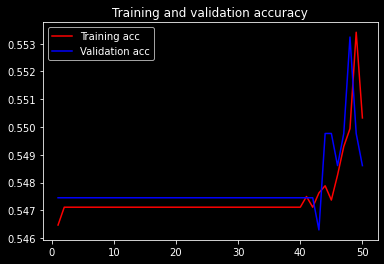

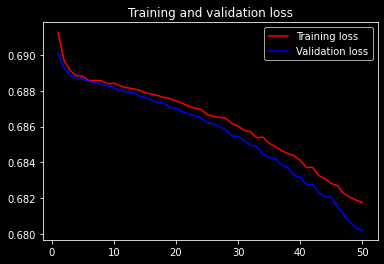

In [66]:
acc = CNN_inc_history.history['accuracy']
val_acc = CNN_inc_history.history['val_accuracy']
loss = CNN_inc_history.history['loss']
val_loss = CNN_inc_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

> ***Step 6 - Viewing results and generating forecasts***

In [67]:
score_inc = CNN_inc.evaluate(test_set)
print("Test Loss:", score_inc[0])
print("Test Accuracy:", score_inc[1])

91/91 [==============================] - 17s 184ms/step - loss: 0.6800 - accuracy: 0.5600
Test Loss: 0.6800490617752075
Test Accuracy: 0.5600277781486511


In [69]:
y_pred_inc = CNN_inc.predict(test_set)
y_pred_inc = np.round(y_pred_inc)

recall_inc = recall_score(y_test, y_pred_inc)
precision_inc = precision_score(y_test, y_pred_inc)
f1_inc = f1_score(y_test, y_pred_inc)
roc_inc = roc_auc_score(y_test, y_pred_inc)

In [70]:
print(classification_report(y_test, y_pred_inc))

              precision    recall  f1-score   support

           0       0.75      0.02      0.05      1288
           1       0.56      0.99      0.71      1594

    accuracy                           0.56      2882
   macro avg       0.65      0.51      0.38      2882
weighted avg       0.64      0.56      0.42      2882



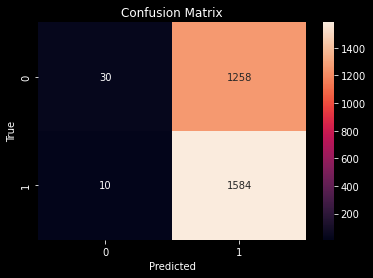

In [71]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_inc),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [72]:
# Save the model
modelFileName = 'fire_classifier_model-inc.h5'
CNN_inc.save(modelFileName)
print('model saved as', modelFileName)

model saved as fire_classifier_model-inc.h5


# **Construction of the third model (Xception)**

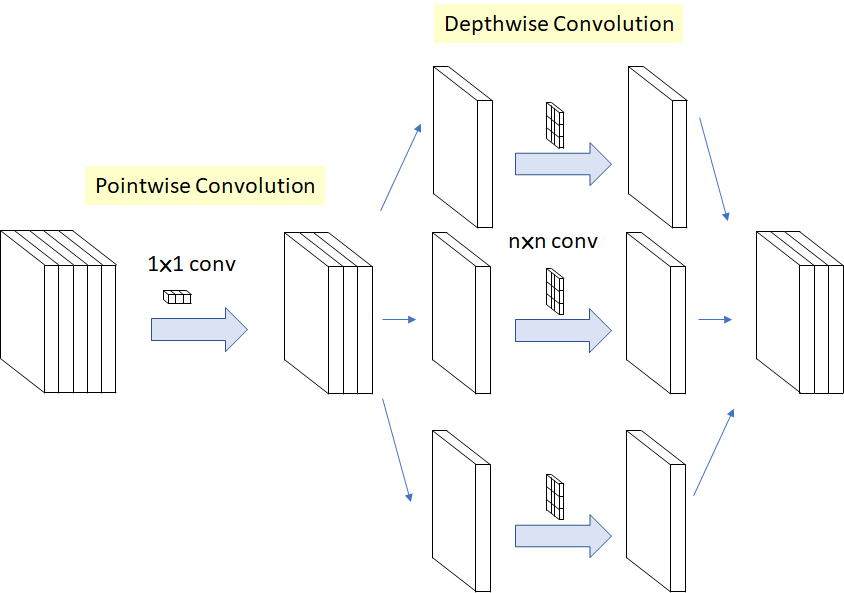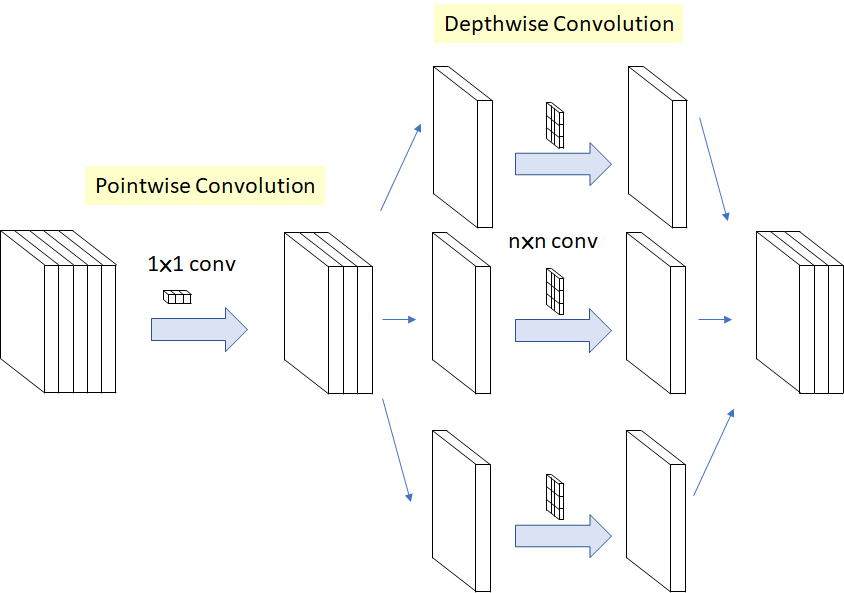

> ***Step 1 - Base model creation***

input_shape - Setting the height/width and RGB channels (128, 128, 3)

include_top - Fully connected layer will not be included on top

weights - Pre-training using None

In [74]:
CNN_base_xcep = Xception(input_shape = (75, 75, 3), include_top = False, weights = None)
CNN_base_xcep.trainable = False

> ***Step 2 - Dense Neural Networks***

Dense - All connected neurons

units - Number of neurons that are part of the hidden layer

activation - Activation function that will be inserted

Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)

In [75]:
CNN_xcep = Sequential()
CNN_xcep.add(CNN_base_xcep)
CNN_xcep.add(GlobalAveragePooling2D())
CNN_xcep.add(Dense(128))
CNN_xcep.add(Dropout(0.1))
CNN_xcep.add(Dense(1, activation = 'sigmoid'))

CNN_xcep.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 21,123,881
Trainable params: 262,401
Non-trainable params: 20,861,480
_________________________________________________________________


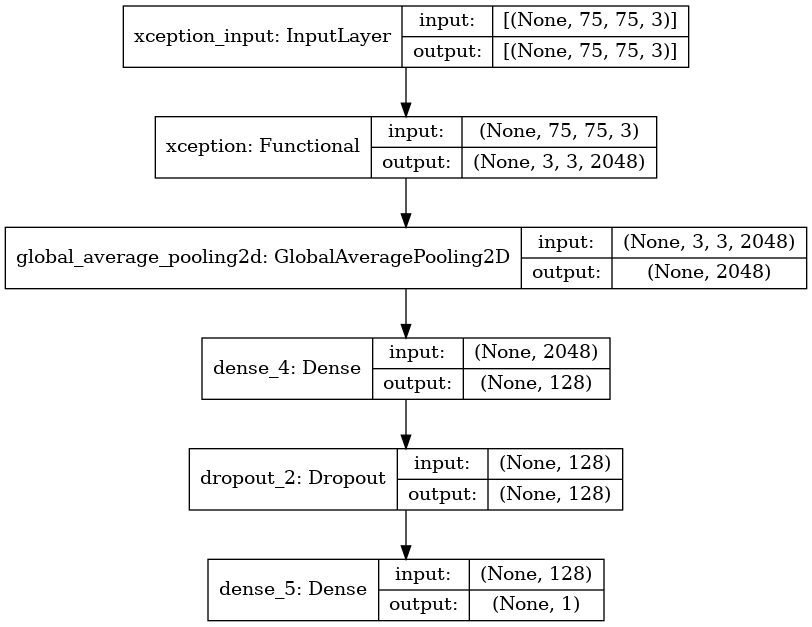

In [76]:
plot_model(CNN_xcep, show_layer_names = True , show_shapes = True)

> ***Step 4 - Model compilation and training***

**Compile parameters:**

optimizer - descent of the gradient and descent of the stochastic gradient

loss - Loss function (binary_crossentropy as there is only one exit)

metrics - Evaluation metrics (obs - more than one can be placed)

**Fit parameters:**

 train_data - training database
 
 epochs - number of seasons
 
 validation_data - test database
 
 callbacks - Using EarlyStopping
 
 validation_steps - number of images to validation

In [77]:
# Compilation
CNN_xcep.compile(optimizer='adam', loss = 'binary_crossentropy',metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_xcep_history = CNN_xcep.fit(training_set, epochs = 50, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_xcep = end - start
print ('\nTraining and validation time: ', time_CNN_xcep)

Epoch 1/50
244/244 [==============================] - 118s 469ms/step - loss: 0.6892 - accuracy: 0.5448 - val_loss: 0.6886 - val_accuracy: 0.5475
Epoch 2/50
244/244 [==============================] - 115s 473ms/step - loss: 0.6889 - accuracy: 0.5471 - val_loss: 0.6889 - val_accuracy: 0.5475
Epoch 3/50
244/244 [==============================] - 115s 473ms/step - loss: 0.6890 - accuracy: 0.5471 - val_loss: 0.6884 - val_accuracy: 0.5475
Epoch 4/50
244/244 [==============================] - 114s 468ms/step - loss: 0.6890 - accuracy: 0.5471 - val_loss: 0.6889 - val_accuracy: 0.5475
Epoch 5/50
244/244 [==============================] - 115s 470ms/step - loss: 0.6888 - accuracy: 0.5471 - val_loss: 0.6886 - val_accuracy: 0.5475
Epoch 6/50
244/244 [==============================] - 113s 465ms/step - loss: 0.6889 - accuracy: 0.5471 - val_loss: 0.6882 - val_accuracy: 0.5475
Epoch 7/50
244/244 [==============================] - 111s 456ms/step - loss: 0.6886 - accuracy: 0.5471 - val_loss: 0.6884 -

> ***Step 5 - Model training history***

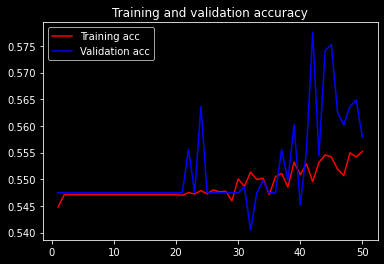

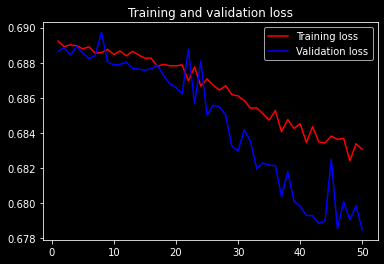

In [78]:
acc = CNN_xcep_history.history['accuracy']
val_acc = CNN_xcep_history.history['val_accuracy']
loss = CNN_xcep_history.history['loss']
val_loss = CNN_xcep_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

> ***Step 8 - Viewing results and generating forecasts***

In [79]:
score_xcep = CNN_xcep.evaluate(test_set)
print("Test Loss:", score_xcep[0])
print("Test Accuracy:", score_xcep[1])

91/91 [==============================] - 33s 361ms/step - loss: 0.6832 - accuracy: 0.5507
Test Loss: 0.6831914782524109
Test Accuracy: 0.5506592392921448


In [80]:
y_pred_xcep = CNN_xcep.predict(test_set)
y_pred_xcep = np.round(y_pred_xcep)

recall_xcep = recall_score(y_test, y_pred_xcep)
precision_xcep = precision_score(y_test, y_pred_xcep)
f1_xcep = f1_score(y_test, y_pred_xcep)
roc_xcep = roc_auc_score(y_test, y_pred_xcep)

In [81]:
print(classification_report(y_test, y_pred_xcep))

              precision    recall  f1-score   support

           0       0.49      0.15      0.23      1288
           1       0.56      0.87      0.68      1594

    accuracy                           0.55      2882
   macro avg       0.53      0.51      0.46      2882
weighted avg       0.53      0.55      0.48      2882



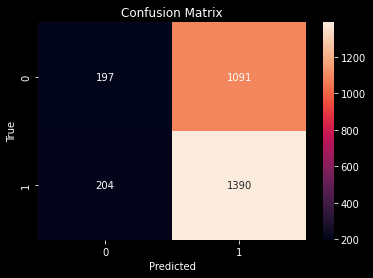

In [82]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_xcep),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [83]:
modelFileName = 'fire_classifier_model-xcep.h5'
CNN_xcep.save(modelFileName)
print('model saved as', modelFileName)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


model saved as fire_classifier_model-xcep.h5


# **Construction of the fourth model (MobileNet)**

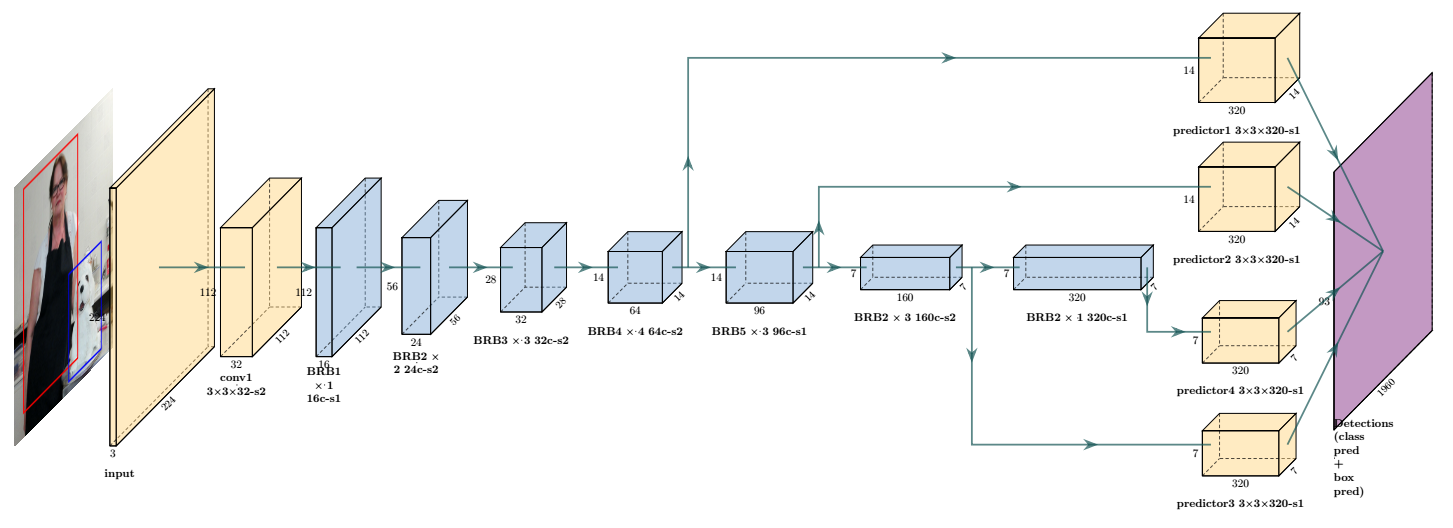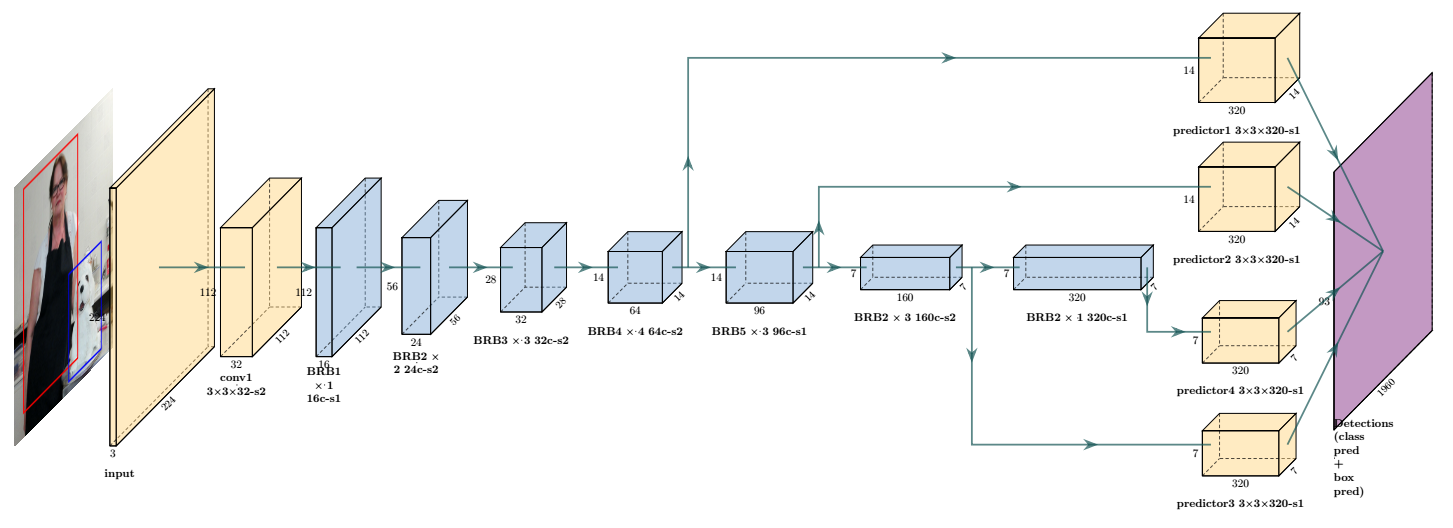

> ***Step 1 - Base model creation***

input_shape - Setting the height/width and RGB channels (128, 128, 3)

include_top - Fully connected layer will not be included on top

weights - Pre-training using None

In [85]:
CNN_base_mobilenet = MobileNet(input_shape = (75, 75, 3), include_top = False, weights = None)

In [86]:
for layer in CNN_base_mobilenet.layers:
    layer.trainable = False

> ***Step 2 - Dense Neural Networks***

Dense - All connected neurons

units - Number of neurons that are part of the hidden layer

activation - Activation function that will be inserted

Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)

In [87]:
CNN_mobilenet = Sequential()
CNN_mobilenet.add(BatchNormalization(input_shape = (75, 75, 3)))
CNN_mobilenet.add(CNN_base_mobilenet)
CNN_mobilenet.add(BatchNormalization())
CNN_mobilenet.add(GlobalAveragePooling2D())
CNN_mobilenet.add(Dropout(0.5))
CNN_mobilenet.add(Dense(1, activation = 'sigmoid'))

CNN_mobilenet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_931 (Bat (None, 75, 75, 3)         12        
_________________________________________________________________
mobilenet_1.00_75 (Functiona (None, 2, 2, 1024)        3228864   
_________________________________________________________________
batch_normalization_932 (Bat (None, 2, 2, 1024)        4096      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1025      
Total params: 3,233,997
Trainable params: 3,079
Non-trainable params: 3,230,918
________________________________________

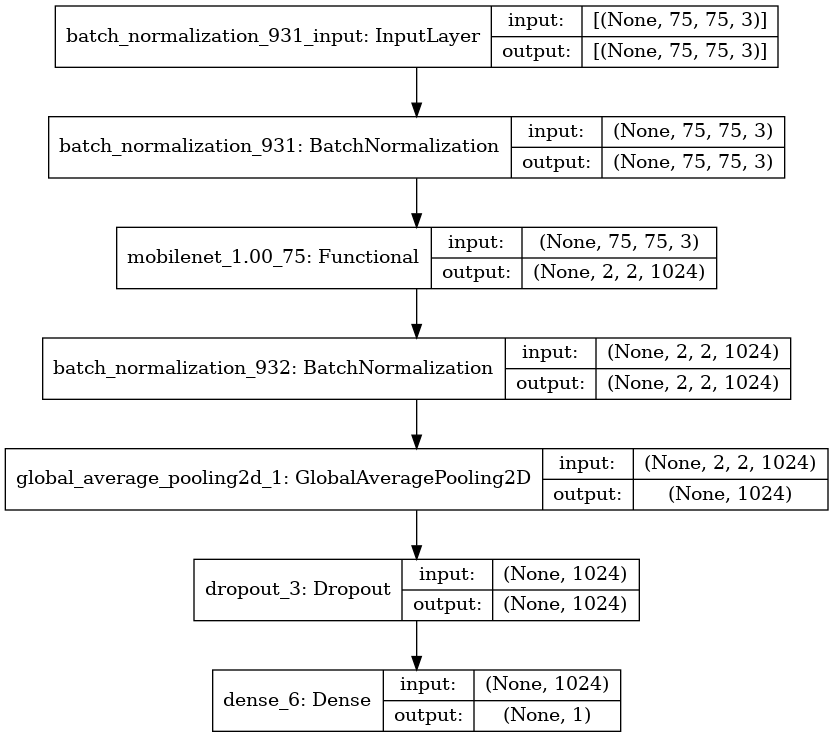

In [88]:
plot_model(CNN_mobilenet, show_layer_names = True , show_shapes = True)

> ***Step 4 - Model compilation and training***

**Compile parameters:**

optimizer - descent of the gradient and descent of the stochastic gradient

loss - Loss function (binary_crossentropy as there is only one exit)

metrics - Evaluation metrics (obs - more than one can be placed)

**Fit parameters:**

 train_data - training database
 
 epochs - number of seasons
 
 validation_data - test database
 
 callbacks - Using EarlyStopping
 
 validation_steps - number of images to validation

In [89]:
# Compilation
CNN_mobilenet.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_mobilenet_history = CNN_mobilenet.fit(training_set, epochs = 50, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_mobilenet = end - start
print ('\nTraining and validation time: ', time_CNN_mobilenet)

Epoch 1/50
244/244 [==============================] - 63s 247ms/step - loss: 0.6893 - accuracy: 0.5466 - val_loss: 0.6894 - val_accuracy: 0.5475
Epoch 2/50
244/244 [==============================] - 60s 244ms/step - loss: 0.6893 - accuracy: 0.5471 - val_loss: 0.6889 - val_accuracy: 0.5475
Epoch 3/50
244/244 [==============================] - 60s 244ms/step - loss: 0.6896 - accuracy: 0.5471 - val_loss: 0.6889 - val_accuracy: 0.5475
Epoch 4/50
244/244 [==============================] - 60s 245ms/step - loss: 0.6892 - accuracy: 0.5462 - val_loss: 0.6887 - val_accuracy: 0.5475
Epoch 5/50
244/244 [==============================] - 60s 244ms/step - loss: 0.6895 - accuracy: 0.5471 - val_loss: 0.6887 - val_accuracy: 0.5475
Epoch 6/50
244/244 [==============================] - 59s 243ms/step - loss: 0.6892 - accuracy: 0.5472 - val_loss: 0.6887 - val_accuracy: 0.5475
Epoch 7/50
244/244 [==============================] - 60s 245ms/step - loss: 0.6893 - accuracy: 0.5466 - val_loss: 0.6888 - val_ac

> ***Step 5 - Model training history***

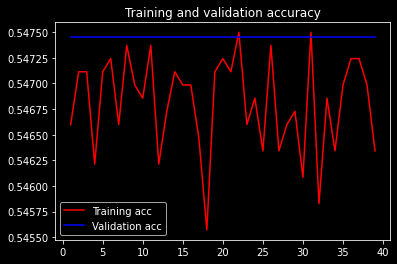

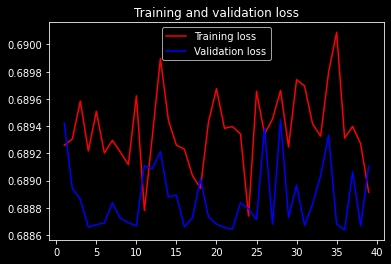

In [100]:
acc = CNN_mobilenet_history.history['accuracy']
val_acc = CNN_mobilenet_history.history['val_accuracy']
loss = CNN_mobilenet_history.history['loss']
val_loss = CNN_mobilenet_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

> ***Step 8 - Viewing results and generating forecasts***

In [101]:
score_mn = CNN_mobilenet.evaluate(test_set)
print("Test Loss:", score_mn[0])
print("Test Accuracy:", score_mn[1])

91/91 [==============================] - 7s 79ms/step - loss: 0.6879 - accuracy: 0.5531
Test Loss: 0.6879196166992188
Test Accuracy: 0.5530881285667419


In [102]:
y_pred_mn = CNN_mobilenet.predict(test_set)
y_pred_mn = np.round(y_pred_mn)

recall_mn = recall_score(y_test, y_pred_mn)
precision_mn = precision_score(y_test, y_pred_mn)
f1_mn = f1_score(y_test, y_pred_mn)
roc_mn = roc_auc_score(y_test, y_pred_mn)

In [103]:
print(classification_report(y_test, y_pred_mn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1288
           1       0.55      1.00      0.71      1594

    accuracy                           0.55      2882
   macro avg       0.28      0.50      0.36      2882
weighted avg       0.31      0.55      0.39      2882



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


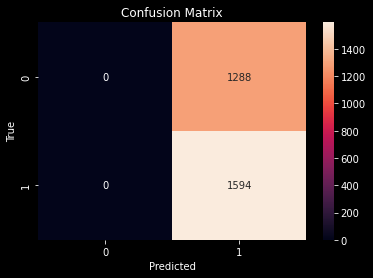

In [104]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_mn),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [105]:
# Save the model
modelFileName = 'fire_classifier_model-mobilenet.h5'
CNN_mobilenet.save(modelFileName)
print('model saved as', modelFileName)

model saved as fire_classifier_model-mobilenet.h5


# **Viewing the results of all models**

In [106]:
models= [('ConvNet', time_CNN, np.mean(CNN_model.history['accuracy']), np.mean(CNN_model.history['val_accuracy'])),
         ('Inception', time_CNN_inc, np.mean(CNN_inc_history.history['accuracy']), np.mean(CNN_inc_history.history['val_accuracy'])),
         ('Xception', time_CNN_xcep, np.mean(CNN_xcep_history.history['accuracy']), np.mean(CNN_xcep_history.history['val_accuracy'])),
         ('MobileNet', time_CNN_mobilenet, np.mean(CNN_mobilenet_history.history['accuracy']), np.mean(CNN_mobilenet_history.history['val_accuracy']))]

df_all_models = pd.DataFrame(models, columns = ['Model', 'Time', 'Training accuracy (%)', 'Validation Accuracy (%)'])

df_all_models

,Model,Time,Training accuracy (%),Validation Accuracy (%)
0,ConvNet,0 days 00:35:10.350879,0.886088,0.869236
1,Inception,0 days 00:52:05.217622,0.547453,0.547778
2,Xception,0 days 01:35:10.187308,0.548978,0.551713
3,MobileNet,0 days 00:39:40.265509,0.546817,0.547454


In [107]:
models = [('ConvNet', score_CNN[1], recall_CNN, precision_CNN, f1_CNN, roc_CNN),
          ('Inception', score_inc[1], recall_inc, precision_inc, f1_inc, roc_inc),
          ('Xception', score_xcep[1], recall_xcep, precision_xcep, f1_xcep, roc_xcep),
          ('MobileNet', score_mn[1], recall_mn, precision_mn, f1_mn, roc_mn)]

df_all_models_testset = pd.DataFrame(models, columns = ['Model', 'Test accuracy (%)', 'Recall (%)', 'Precision (%)', 'F1 (%)', 'AUC'])

df_all_models_testset

,Model,Test accuracy (%),Recall (%),Precision (%),F1 (%),AUC
0,ConvNet,0.930604,0.964241,0.914881,0.938913,0.926608
1,Inception,0.560028,0.993726,0.557354,0.714157,0.508509
2,Xception,0.550659,0.872020,0.560258,0.682209,0.512485
3,MobileNet,0.553088,1.000000,0.553088,0.712243,0.500000


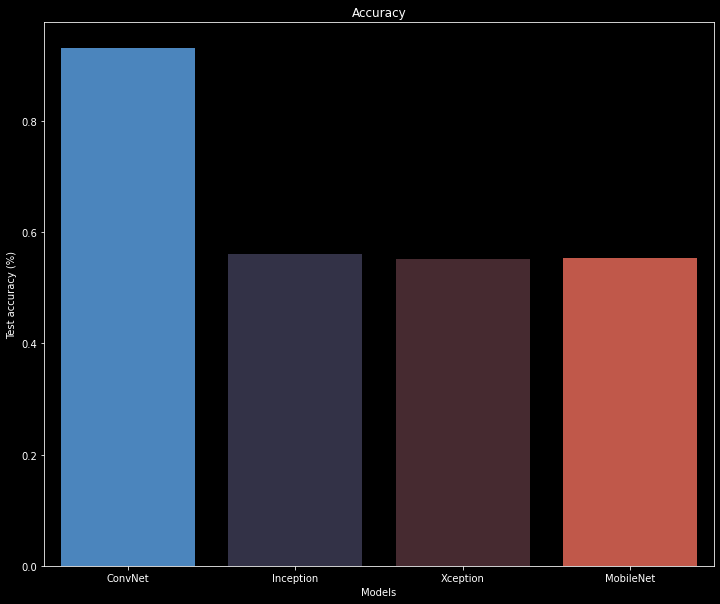

In [108]:
plt.subplots(figsize=(12, 10))
sns.barplot(y = df_all_models_testset['Test accuracy (%)'], x = df_all_models_testset['Model'], palette = 'icefire')
plt.xlabel("Models")
plt.title('Accuracy')
plt.show()

In [109]:
r_probs = [0 for _ in range(len(y_test))]
r_auc = roc_auc_score(y_test, r_probs)
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)

fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_CNN)
fpr_inc, tpr_inc, _ = roc_curve(y_test, y_pred_inc)
fpr_xcep, tpr_xcep, _ = roc_curve(y_test, y_pred_xcep)
fpr_mn, tpr_mn, _ = roc_curve(y_test, y_pred_mn)

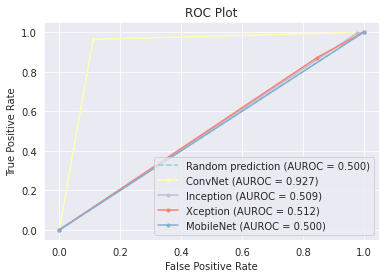

In [110]:
sns.set_style('darkgrid')

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)

plt.plot(fpr_cnn, tpr_cnn, marker='.', label='ConvNet (AUROC = %0.3f)' % roc_CNN)
plt.plot(fpr_inc, tpr_inc, marker='.', label='Inception (AUROC = %0.3f)' % roc_inc)
plt.plot(fpr_xcep, tpr_xcep, marker='.', label='Xception (AUROC = %0.3f)' % roc_xcep)
plt.plot(fpr_mn, tpr_mn, marker='.', label='MobileNet (AUROC = %0.3f)' % roc_mn)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()

In [111]:
test_set.class_indices

{'femaleeyes': 0, 'maleeyes': 1}

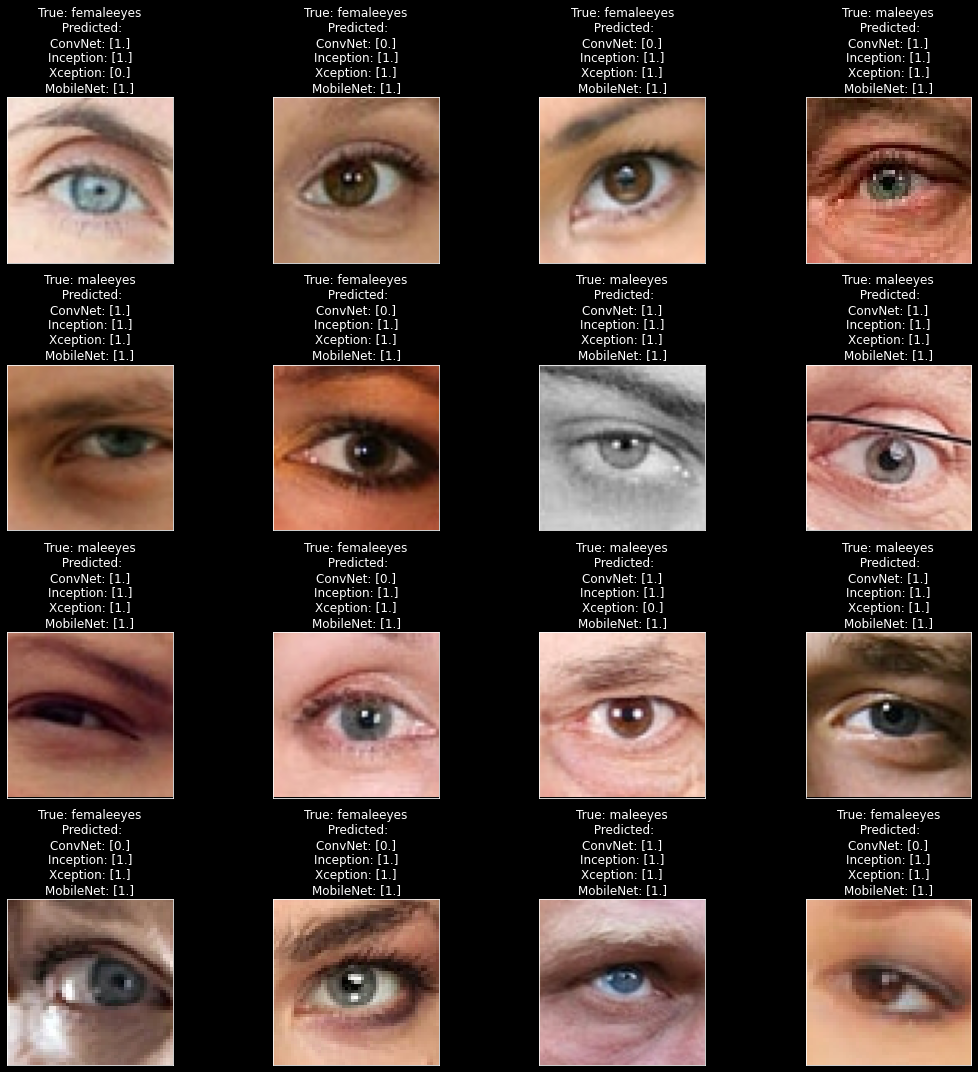

In [112]:
plt.style.use("dark_background")


fig, axes = plt.subplots(nrows = 4,
                         ncols = 4,
                         figsize = (15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testset_df["File"].iloc[i]))
    ax.set_title(f"True: {testset_df.Label.iloc[i]}\n Predicted:\nConvNet: {y_pred_CNN[i]}\nInception: {y_pred_inc[i]}\nXception: {y_pred_xcep[i]}\nMobileNet: {y_pred_mn[i]}")
plt.tight_layout()
plt.show()